In [1]:
import torch
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
from matplotlib.patches import Rectangle
from PIL import Image
import imageio
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2

from src.models.unet import BaseUNet

In [2]:
def dice_coefficient(pred, target, threshold=0.5):
    pred = (pred > threshold).astype(np.uint8).flatten()
    target = (target > threshold).astype(np.uint8).flatten()
    
    intersection = np.sum(pred * target)
    return (2. * intersection) / (np.sum(pred) + np.sum(target) + 1e-6)

In [3]:
def overlay_mask_on_image(image, mask, alpha=0.5, color=(0, 255, 0)):

    overlay = image.copy()
    overlay[mask > 0] = color
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

def visualize_batch(images, predicteds, ground_truths, idx, gif_frames_preds, gif_frames_gt):
    batch_size = len(images)
    fig, ax = plt.subplots(batch_size, 3, figsize=(7.5, 30))

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    predicteds = predicteds.cpu().numpy()
    ground_truths = ground_truths.cpu().numpy()
    dice_scores = []
    for i in range(batch_size):

        img = images[i]
        predicted = predicteds[i].squeeze()
        ground_truth = ground_truths[i].squeeze()
        
        img_gray = (img.squeeze() * 255).astype(np.uint8)  
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_gray)
        

        img_3c = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        
        # Overlay mask on the image
        img_with_pred = overlay_mask_on_image(img_3c, predicted, color=(0, 255, 0))
        img_with_gt   = overlay_mask_on_image(img_3c, ground_truth, color=(0, 0, 255))
        
        dice_score = dice_coefficient(predicted, ground_truth)
        dice_scores.append(dice_score)
        
        
        ax[i][0].imshow(img, cmap='gray')
        ax[i][0].set_title('Original Image', fontsize=10)
        
        ax[i][1].imshow(img_clahe, cmap='bone')
        ax[i][1].imshow(img_with_pred, alpha=0.5, cmap='gray')
        ax[i][1].set_title('Image with predicted', fontsize=10)
        
        ax[i][2].imshow(img_clahe, cmap='bone')
        ax[i][2].imshow(img_with_gt, alpha=0.5, cmap='gray')
        ax[i][2].set_title('Image with ground truth', fontsize=10)
        
        for j in range(3):
            ax[i][j].set_yticks([])
            ax[i][j].set_xticks([])

        #combined_img = ax[i][1].get_images()[0].make_image(renderer=None, unsampled=True)[0]
        gif_frames_preds.append(img_with_pred)
        gif_frames_gt.append(img_with_gt)
        #gif_frames.append(combined_img)
    
    plt.tight_layout()
    plt.savefig(f'batch_{idx}.jpg')
    print(np.mean(dice_scores))
    print("image saved")


# images       = images
# predicted    = outputs
# ground_truth = masks
# visualize_batch(images, predicted, ground_truth)


In [4]:
def create_gif(gif_frames, gif_path, duration=0.5):
    imageio.mimsave(gif_path, gif_frames, duration=duration)
    print(f"GIF saved at {gif_path}")

In [5]:
device = 'cuda:0'
load_path = '/home/syurtseven/gsoc-2024/reports/seg/2/model/model_20.pt'
model  = BaseUNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(load_path))
model  = model.to(device)

In [7]:
img_list  = sorted(glob.glob(os.path.join("/home/syurtseven/gsoc-2024/data/stomach_masks", '*image*.png')))
mask_list = sorted(glob.glob(os.path.join("/home/syurtseven/gsoc-2024/data/stomach_masks", '*mask*.png')))
bs = 45  
img_batch_list = [] 
mask_batch_list = []  
length_batch_list = []  


for idx in range(0, len(img_list), bs):
    img_seq_batch = []
    mask_seq_batch = []  
    for i in range(len(img_list[idx:idx + bs])):
        i += idx  
        if i + 1 >= len(img_list):
            break  
        key = '_'.join(img_list[i + 1].split('/')[-1].split('_')[:2])
        cokey = '_'.join(img_list[i].split('/')[-1].split('_')[:2])

        if key != cokey:
            # print("Mismatch keys found:")
            # print(f"key: {key}")
            # print(f"cokey: {cokey}")
            break
        
        img_seq_batch.append(img_list[i])
        mask_seq_batch.append(mask_list[i])
        
    img_batch_list.append(img_seq_batch)
    mask_batch_list.append(mask_seq_batch)

# print the batch lists to check the batches created
for idx, (img_batch, mask_batch) in enumerate(zip(img_batch_list, mask_batch_list)):
    print(f"Image Batch {idx + 1}: {img_batch}")
    print(f"Mask Batch {idx + 1}: {mask_batch}")
    length_batch_list.append(len(img_batch))

# print the lengths of each batch
for idx, length in enumerate(length_batch_list):
    print(f"Length of Batch {idx + 1}: {length}")


Image Batch 1: ['/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0066_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0067_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0068_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0069_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0070_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0071_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0072_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0073_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0074_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0075_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20_slice_0076_image.png', '/home/syurtseven/gsoc-2024/data/stomach_masks/case101_day20

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

0.9274237387925064
image saved


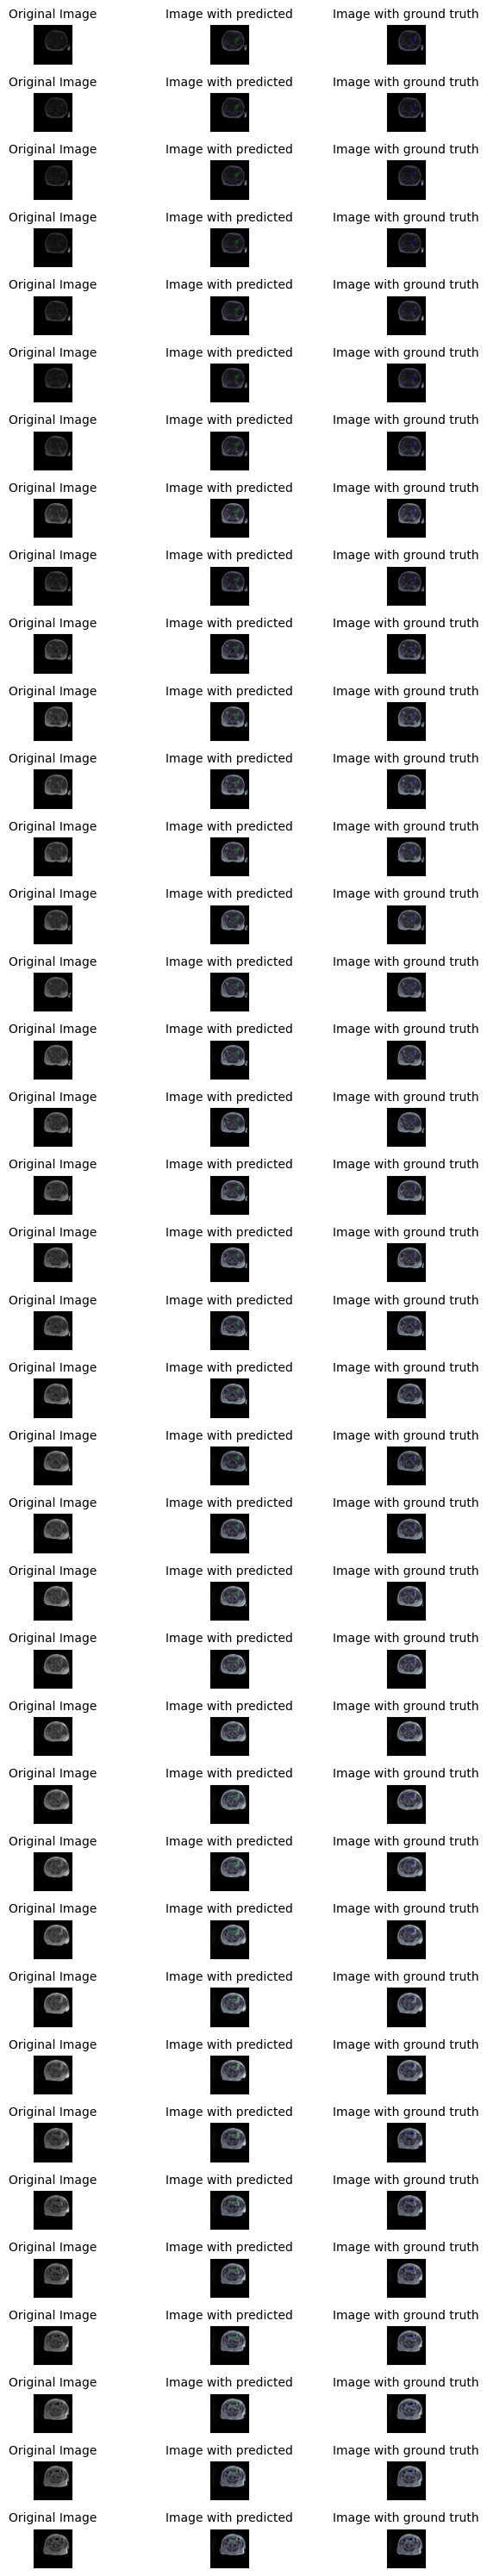

In [8]:
count = 0
gif_frames_preds = []
gif_frames_gt = []
for idxs, (img_batch, mask_batch) in enumerate(zip(img_batch_list, mask_batch_list)):
    # print(f"Image Batch {idx + 1}: {img_batch}")
    # print(f"Mask Batch {idx + 1}: {mask_batch}")
    batch_img  = []
    batch_mask = []

    for idx, (img, mask) in enumerate(zip(img_batch, mask_batch)):

        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask, cv2.IMREAD_UNCHANGED)
        img = transform(img)
        mask = transform(mask)
        
        batch_img.append(img)
        batch_mask.append(mask)

    if len(batch_img) == bs and len(batch_mask) == bs:
        batch_img = torch.stack(batch_img)
        batch_mask = torch.stack(batch_mask)

        with torch.no_grad():
            images, masks = batch_img.to(device), batch_mask.to(device)
            outputs = model(images)
            
            if idxs < 5:
                count +=1
                images       = images
                predicted    = outputs
                ground_truth = masks
                visualize_batch(images, predicted, ground_truth, count, gif_frames_preds, gif_frames_gt)
            else:
                break

In [9]:
create_gif(gif_frames_preds, 'predicted.gif', duration=0.5)
create_gif(gif_frames_gt, 'ground_truth.gif', duration=0.5)

GIF saved at predicted.gif
GIF saved at ground_truth.gif


In [ ]:
len(gif_frames_preds)